# Q Estimation - Spectral ratio

## Import Modules

In [5240]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
import segyio

## Load in Trace data

In [5241]:
data = np.loadtxt(fname = 'Syn Traces/RickerConstQNoise150.txt')
#data = np.loadtxt(fname = 'Syn Traces/Q150Noise10Events.txt')
#data = np.loadtxt(fname = 'Syn Traces/RickerShallowGas.txt')
#data = np.loadtxt(fname = 'Syn Traces/RickerNoQ.txt')
time =np.loadtxt(fname = 'Syn Traces/4s0.004time.txt')
#time = np.loadtxt(fname = 'Syn Traces/2Sec0.004time.txt')



segy = segyio.open('finalstack.sgy', ignore_geometry= True)
data = datawhole[0:500,301] # Single trace
time = time[0:len(data)]


In [5242]:
len(time)


500

In [5243]:

ntrace = len(segy.trace)
ltrace = len(segy._samples)

dt = segy._samples[1] - segy._samples[0]

datawhole = np.zeros([ltrace,ntrace])
a = 0
i = 0
for trace in segy.trace:
    datawhole[:,a] = np.asarray(trace[0:ltrace] * 1.0)
    a=a+1
    

In [5244]:
data = datawhole[0:500,301] # Single trace
time = time[0:len(data)]


## Sense Trace Parameters

In [5246]:
# Sample Rate
dt = round(max(time)/len(data),3)
#Sample Frequency
fs = 1/dt # fs = a scalar which is the sampling frequency of the data
Ts = dt

In [5247]:
#Define Window length:
wl = 32# for 100ms at 0.004 sampling = 25
#half window length
hwl = int(round(wl/2))
lbw = 3
ubw =30 # bandwidth

lbw = 1
ubw = 14


#### Checking trace loaded correctly

Text(0, 0.5, 'Amplitude')

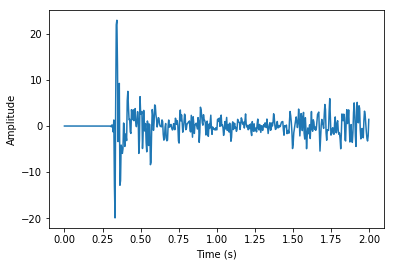

In [5248]:
plt.plot(time,data)
plt.xlabel('Time (s)' )
plt.ylabel('Amplitude' )

### Look at amplitude spectrum of whole trace

<module 'matplotlib.pyplot' from 'C:\\Users\\ee18s2p\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

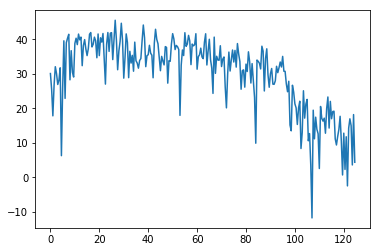

In [5249]:
amp = np.abs(np.fft.fft(data))
f=np.arange(0,(len(data)/2))/len(data)*fs
nq = np.int64(np.ceil(len(amp)/2))

plt.plot(f,20*np.log10(amp[0:nq]))
plt


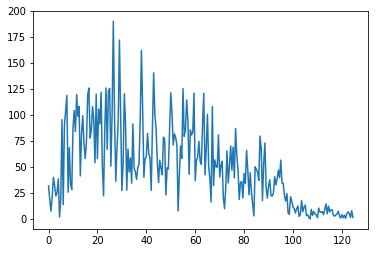

In [5250]:
plt.plot(f,(amp[0:nq]))

## Hilbert Transform of trace and windows

In [5251]:
analytical_signal = sp.hilbert(data)
amplitude_envelope = np.abs(analytical_signal)

In [5252]:

maxs = np.empty([0,4])
tot = len(amplitude_envelope)

maxx = np.argmax(amplitude_envelope)

# finds max at least every 10 to get seperate events
for ty in range(4):
    maxx = np.argmax(amplitude_envelope[maxx+10:tot]) +  maxx +10
    maxs = np.append(maxs,[maxx])

maxx = np.argmax(amplitude_envelope)
display(maxx)
# add first max back 
maxs = np.insert(maxs,0,maxx)

84

In [5253]:
sorted_array = np.argsort(amplitude_envelope)
reverse_array = sorted_array[::-1]
time[reverse_array[0:24]]

array([0.336, 0.34 , 0.332, 0.344, 0.364, 0.348, 0.36 , 0.328, 0.368,
       0.352, 0.412, 0.568, 0.564, 0.572, 0.408, 0.416, 0.492, 0.488,
       0.496, 0.384, 0.508, 0.512, 1.74 , 1.816])

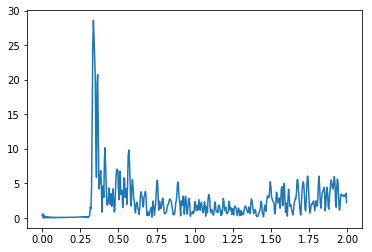

In [5254]:
plt.plot(time,amplitude_envelope)


0.132 0.332 0.532 0.732 0.932

In [5255]:

rollalong = np.int32(np.floor(wl *0.5))

total_segments = np.int32(np.ceil(len(amplitude_envelope) / np.float32(rollalong)))
 
# Pad data with zeroes
padded = np.concatenate((amplitude_envelope, np.zeros(wl)))             
paddedtime = np.concatenate((time, np.zeros(wl)))  
#Define storage arrays

result = np.empty((total_segments, wl), dtype=np.float32)   
hilwindow = np.empty((0, wl))
timewindow = np.empty((0, wl))

#Roll along trace applying window function and fft
for i in range(total_segments):                     
    currentroll = rollalong * i                     
    segment = padded[currentroll:currentroll+wl]       
    hilwindow = np.append(hilwindow,[segment], axis = 0)
    
    timesegment = paddedtime[currentroll:currentroll+wl]       
    timewindow = np.append(timewindow,[timesegment])

In [5256]:
#RMS of hilbert for each window
rmshil = np.empty((0, wl))

for i in range(total_segments):
    RMS = np.sqrt(np.sum(np.square(hilwindow[i])))
    rmshil = np.append(rmshil,[RMS])

## Apply windowing function and fft

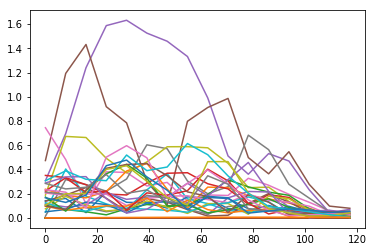

In [5257]:
# Create frequency array
f=np.arange(0,(round(wl/2)))/wl*fs
t = np.arange(0,(wl/2))/wl*dt
# Define window roll along with 50% overlap of previous window
rollalong = np.int32(np.floor(wl*0.5))

total_segments = np.int32(np.ceil(len(data) / np.float32(rollalong)))

# Define Window function
window = np.hanning(wl)  
 
# Pad data with zeroes
padded = np.concatenate((data, np.zeros(wl)))             

#Define storage arrays
result = np.empty((total_segments, wl), dtype=np.float32)   
windoww = np.empty((0, wl))

#Roll along trace applying window function and fft
for i in range(total_segments):                     
    currentroll = rollalong * i                     
    segment = padded[currentroll:currentroll+wl]       
    windoww = np.append(windoww,[segment], axis = 0)
    windowed = segment * window                       
    amp = np.fft.fft(windowed) / wl            
    amplitude = np.abs(amp) 
    result[i, :] = amplitude[:wl]
    plt.plot(f,result[i,0:hwl])

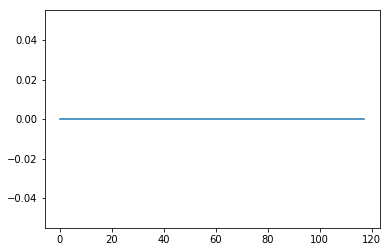

In [5258]:
plt.plot(f,result[0,0:hwl])

#### Test stft

In [5259]:
#f = np.linspace(0,len(data)/2/len(data)*fs,17)

In [5260]:
#f,time,z = sp.stft(data,fs,window='hann',nperseg = 34,noverlap=16)
#result = np.abs(z)


##  Test for a single spectrum
#### With defined window over signal

58.82218431265752

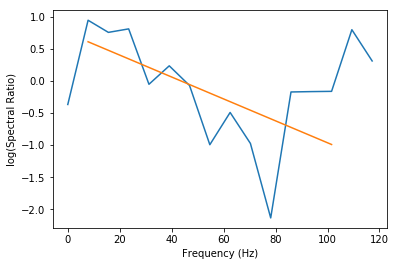

In [5261]:
x = f[lbw:ubw]

sww =5
#ratio =  np.log(result[23,:]/ result[12,:])
ratio =  np.log(result[18]/ result[12])
[p,c] =  np.polyfit(x,ratio[lbw:ubw],1)

yfit = c + p*x

plt.plot(f,ratio[0:hwl])
plt.plot(x,yfit[0:ubw])
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(Spectral Ratio)')

t = (sww*wl*0.5)*dt
q = -1*np.pi*t/p
display(q)

# Automated Calculating spectral ratio, Gradient and Q

C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


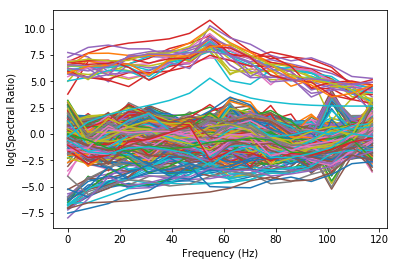

In [5262]:
sq = []
ratio2 = []
t1 = []
res1 = []
upl =[]
lol = []
var =[]
qerror = []
product = []
# Window spacing starts at 0
ws = 0
# Frequency bandwidth to fit data
x = f[lbw:ubw]

for j in range(1,total_segments-ws):
    ws = j # windowspacing
    for i in range (0,total_segments-ws): 
        # calculate spectral ratio
        ratio =  np.log(result[i+ws, :]/ result[i, :])
        ratio2 = np.append(ratio2, [ratio])
        
        where_are_NaNs = np.isnan(ratio)
        ratio[where_are_NaNs] = 0
        # least-squares fit to find gradient 
        [p,c] =  np.polyfit(x,ratio[lbw:ubw],1)
        yfit = c + p*x
        
        # Error on slope
        [z,V] =  np.polyfit(x,ratio[lbw:ubw],1,cov=True)
        varr = np.sqrt(np.diag(V)[0])
        var = np.append(var,[varr]) 
        
        # Calculate Residuals and save to array
        r = ratio[lbw:ubw] -yfit
        res1 = np.append(res1,[r])
    
        # calculate time difference between windows and save to arry
        t = (ws*wl*0.5)*dt        
        t1 = np.append(t1,[t],axis = 0)
        # Calulate Q and save to array
        q = -1*np.pi*t/p
        sq = np.append(sq,[q],axis = 0)
        
        #Q error
        qe = varr*np.abs(-1*np.pi*t/(np.square(p)))
        qerror = np.append(qerror,[qe],axis = 0)
       
        # Upper Window and save to array
        up = i+ws
        upl = np.append(upl,[up], axis = 0)       
        
        #Lower Window and save to array
        l = i
        lol = np.append(lol,[l])
        
        # Compare hilbert of windows
        prod = (rmshil[i])*rmshil[i+ws]
        product = np.append(product,[prod])
        
        #PLot spectral ratios and best fit line
        plt.plot(f,ratio[0:hwl])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('log(Spectral Ratio)')
        #plt.plot(x,yfit,'k')

In [5263]:
#where_are_NaNs = np.isnan(sq)
#sq[where_are_NaNs] = 0

#where_are_Infs = np.isinf(sq)
#sq[where_are_Infs] = 0

ind= ~np.isnan(sq)
sq = sq[ind]

ind2= ~np.isinf(sq)
sq  = sq[ind2]

upl = upl[ind]
upl = upl[ind2]

lol = lol[ind]
lol = lol[ind2]

product = product[ind]
product = product[ind2]


qerror = qerror[~np.isnan(qerror)]
qerror = qerror[~np.isinf(qerror)]

In [5264]:
#ratio = np.reshape(ratio2,(len(sq), wl))
#
#ress = np.split(res1,len(sq))
#RSS = []
#for l in range(0,len(sq)):
#    rss = np.sum(np.square(ress[l]))
#    RSS = np.append(RSS,[rss])

In [5265]:
where_are_NaNs = np.isnan(product)
product[where_are_NaNs] = 0

#### Identify events from product of hilbert (largest values)

In [5266]:
sorted_array = np.argsort(product)
reverse_array = sorted_array[::-1]

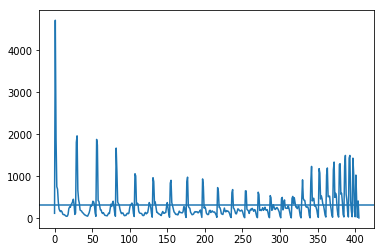

In [5267]:
plt.plot(product)
me = np.mean(product)
plt.axhline(y=me)

tr = product<me
good = product[tr]


x = f[lbw:ubw]
sg = []
for g in range(0,top):
    ratiob =  np.log(result[bestup[g],:]/ result[bestlow[g],:])
    [p,k] =  np.polyfit(x,ratiob[lbw:ubw],1)
    yfit = k + p*x
    # calculate time difference between windows and save to arry
    space = bestup[g]-bestlow[g]
    t = (space*wl*0.5)*dt        
    # Calulate Q and save to array
    q = -1*np.pi*t/p
    sg = np.append(sg,[q],axis = 0)
    
    plt.plot(f,ratiob[0:hwl])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(Spectral Ratio)')
    plt.plot(x,yfit,'k')
display(sg)

#### Find window combination relating to largest values

In [5268]:
bestlow = []
bestup = []
top = 10 #number of expected best values
for m in range(0,top):
        best = upl[reverse_array[m]]
        bestup = np.append(bestup,[best])
        
        bestl = lol[reverse_array[m]]
        bestlow = np.append(bestlow,[bestl])

In [5269]:
bestlow = np.array(bestlow, dtype=np.int64)
bestup = np.array(bestup, dtype=np.int64)
display(bestlow)
display(bestup)

array([4, 5, 5, 4, 4, 5, 4, 5, 5, 4], dtype=int64)

array([ 5,  7,  6,  7,  6,  8,  8, 28, 29, 28], dtype=int64)

array([-32.40387823, -42.52295914, -48.18437858, -38.51391858,
       -38.74909047,  56.70315016, 181.43378822, 392.54930854,
       526.56170761, 865.46164272])

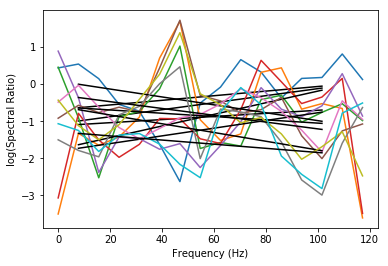

In [5270]:
x = f[lbw:ubw]
sg = []
for g in range(0,top):
    ratiob =  np.log(result[bestup[g],:]/ result[bestlow[g],:])
    [p,k] =  np.polyfit(x,ratiob[lbw:ubw],1)
    yfit = k + p*x
    # calculate time difference between windows and save to arry
    space = bestup[g]-bestlow[g]
    t = (space*wl*0.5)*dt        
    # Calulate Q and save to array
    q = -1*np.pi*t/p
    sg = np.append(sg,[q],axis = 0)
    
    plt.plot(f,ratiob[0:hwl])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(Spectral Ratio)')
    plt.plot(x,yfit,'k')
display(sg)
     

No Noise - Largest Products give best estimates of Q - (except for the largest?)

Noise - Slightly less good estimates - ( largest is still way out?)

#### Product combined with error

In [5271]:
#comb = product/var

### QC plots

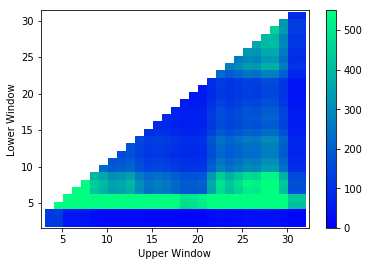

In [5272]:
plt.scatter(upl,lol,c=(product),s=300,marker='s',cmap='winter',vmin=0, vmax=550)
plt.ylabel('Lower Window')
plt.xlabel('Upper Window')
plt.colorbar()
plt.show()

#### Plot of 1/Q against window positions 


224.2603265418964

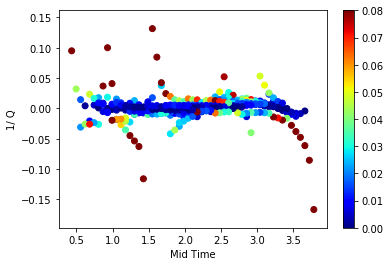

In [5273]:
upt = upl*ws*dt
lpt = lol*ws*dt
mid = (upt+lpt)/2
tdif =upt-lpt 
tdif = mid
plt.scatter( tdif,1/sq,c =1/qerror,cmap='jet',vmin=0, vmax=0.08)
[gr,inte] =  np.polyfit(tdif,1/sq,1)
qfit = inte + gr*tdif


#plt.scatter(tdif,qfit,c =qerror,cmap='jet')
plt.ylabel('1/ Q')
plt.xlabel('Mid Time')
plt.colorbar()
display(1/inte)

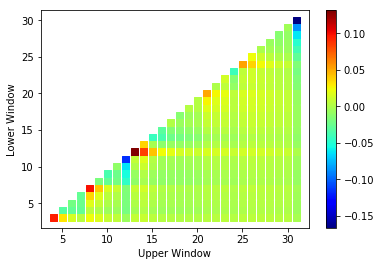

In [5274]:
plt.scatter(upl,lol,c=(1/sq),s=50,marker='s',cmap='jet')#,vmin=-0.02, vmax=0.02)
plt.ylabel('Lower Window')
plt.xlabel('Upper Window')
plt.colorbar()
plt.show()

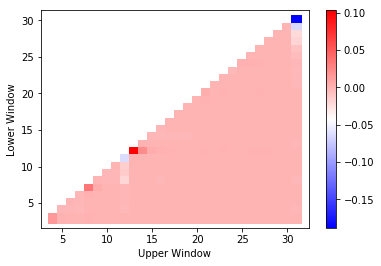

In [5275]:
plt.scatter(upl,lol,c=((1/sq)*(1/qerror)),s=100,marker='s',cmap='bwr')
plt.ylabel('Lower Window')
plt.xlabel('Upper Window')
plt.colorbar()
plt.show()

#### Residual sum of squares/

In [5276]:
#ratio = np.reshape(ratio2,(len(sq), wl))##
#
#ress = np.split(res1,len(sq))
#RSS = []
#for l in range(0,len(sq)):
    #rss = np.sum(np.square(ress[l]))
    #RSS = np.append(RSS,[rss])

#### PLot of Q against residuals

In [5277]:
#plt.plot(RSS,1/sq,'.')
#[grss,inter] =  np.polyfit(RSS,1/sq,1)
#qrssfit = inter + grss*RSS
#plt.plot(RSS,qrssfit)
#display(1/inter)

###### (For noise free trace )Seems to show reasonable cluster of values around true Q values at low SSR - though may not be the best metric
###### (Noisy Trace shows no real correlation)

In [5278]:
#plt.plot(RSS,sq,'.')
#plt.ylim(25,250)

### Window over certain times from maximums of analytic signal

In [5279]:
maxs = np.array(maxs, dtype=np.int64)
windup = maxs +(wl/2)
winddown = maxs -(wl/2)

#windup = maxs +wl
#winddown = maxs 

#windup = maxs
#winddown = maxs -wl


print(time[maxs])
results = []#np.empty((len(maxs), wl))

for po in range(len(maxs)):
    
    windowss  = data[int(winddown[po]):int(windup[po])]
    ampl = np.fft.fft(windowss) / wl 
    amplitudea = np.abs(ampl)  
    results = np.append(results,[amplitudea[:wl]])
    

[0.336 0.412 0.568 1.74  1.816]


In [5280]:
np.shape(results)

(160,)

In [5281]:
results = np.reshape(results,(int(len(results)/wl),wl,))

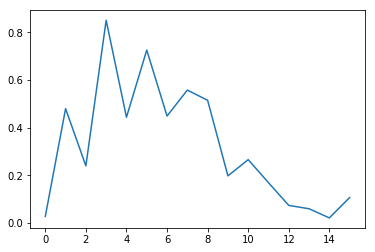

In [5282]:
plt.plot(results[3,:hwl])

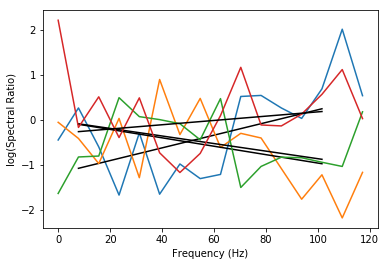

In [5283]:
x = f[lbw:ubw]
sf = []
specs =[]
var = []
res2 = []
qerrorm = []
for gh in range(len(maxs)-1):
    spec =  np.log(results[gh+1,0:hwl]/ results[gh,0:hwl])
    specs = np.append(specs,[spec])
    
    [grr,inn] =  np.polyfit(x,spec[lbw:ubw],1)
    yfit = inn + grr*x
    
    # calculate time difference between windows and save to arry
    
    [z,V] =  np.polyfit(x,spec[lbw:ubw],1,cov=True)
    vard = np.sqrt(np.diag(V)[0])
    var = np.append(var,[vard]) 
    
    r = spec[lbw:ubw] -yfit
    res2 = np.append(res2,[r])
    
    
    t = time[maxs[gh+1]] - time[maxs[gh]]
    # Calulate Q and save to array   
    q = -1*np.pi*t/grr
    sf = np.append(sf,[q],axis = 0)
    
    #Q error
    qer = np.sqrt(vard)*np.abs(-1*np.pi*t/(np.square(grr)))
    qerrorm = np.append(qerrorm,[qer],axis = 0)
    
    plt.plot(f,spec[0:hwl])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(Spectral Ratio)')
    plt.plot(x,yfit,'k')

In [5284]:
print(time[maxs])

[0.336 0.412 0.568 1.74  1.816]


In [5285]:
sf

array([-16.90206914,  52.35117241, 437.25034169, -50.01190997])

In [5286]:
qerrorm

array([ 103.50571745,  460.2196958 , 3881.65676532,  821.5347198 ])

In [5287]:
specs = np.reshape(specs,(len(maxs)-1,int(wl/2)))

In [5288]:
#-13.03185988, 135.53800112, 184.97289782, -17.70075545

In [5289]:
print(time[maxs])

[0.336 0.412 0.568 1.74  1.816]


### With events found now need to decide on bandwidths

#### As only upper frequency should decrease, keep lower freq constant and lower the upper to get best fit?
#### Also only keeping intercepets of <1 as Transmission effects cannot be greater than 1 so then finding best Q from this range?

In [5290]:
lbw = 0
ubw = 0




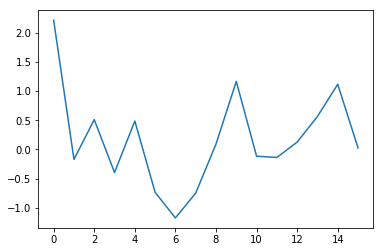

In [5291]:
plt.plot(specs[3])

## Centroid Freq
##### Appears to be ~ factor of 10 out of accurate Q value? 


In [5292]:
spectral_centroid =np.empty([total_segments,1])
specvar =np.empty([total_segments,1])

for st in range(total_segments):
    spectrum = result[st,0:hwl]
    
    normalized_spectrum = spectrum / np.sum(spectrum)  
    
    spectral_centroid[st] = np.sum(f * normalized_spectrum)
    
    specvar[st] = (np.sum(np.square(f - spectral_centroid[j]) * spectrum)) / np.sum(spectrum) 

C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [5293]:
ws = 0
cfq = []
lpw = []
upw = []
for j in range(1,total_segments-ws):
    ws = j # windowspacing
    for fq in range (0,total_segments-ws):
        
        tsp = (ws*wl*0.5)*dt
        
        # Upper Window and save to array
        upt = fq+ws
        upw = np.append(upw,[upt], axis = 0)       
        
        #Lower Window and save to array
        lo = fq
        lpw = np.append(lpw,[lo])
    
            
        cf =  (np.pi*specvar[fq]*tsp)/(spectral_centroid[fq]-spectral_centroid[fq+ws])
        cfq = np.append(cfq,[cf])

In [5294]:
ind3= ~np.isnan(cfq)
cfq = cfq[ind3]
upw = upw[ind3]
lpw = lpw[ind3]

In [5295]:
1/np.mean(1/cfq)

4547.814574990789

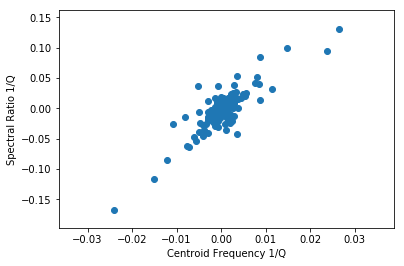

In [5296]:
plt.scatter(1/cfq,1/sq )
plt.xlabel('Centroid Frequency 1/Q')
plt.ylabel('Spectral Ratio 1/Q')
    
[grr,inn] =  np.polyfit(1/cfq,1/sq,1)
yfit = inn + grr*1/cfq
resq = 1/sq - yfit
#plt.plot(1/cfq,yfit,'k')

